# **Part 1: Email Subject Classifier**

**Goal**: Classify emails as spam or not spam based on their subject lines and contents where 0 is not spam and 1 is spam !

## **1. Importing Dataset**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

# Load the dataset
df = pd.read_csv('./data/dataset_subject.csv')

In [6]:
df.head(10)

,Unnamed: 0.1,Unnamed: 0,Body,Label
0,0,323,Subject: a personal message . . . . .\n \n we ...,1
1,1,375,Subject: re : call me now 732-942 - 7100\n \n ...,1
2,2,1349,Subject: request for discourse list\n \n dear ...,0
3,3,197,Subject: move over bill gates ! ! ! ! ! ! ! !\...,1
4,4,147,Subject: 50 % return on investment . . .\n \n ...,1
5,5,1319,Subject: \n \n journal of japanese linguistics...,0
6,6,83,"Subject: your free info .\n \n dear nlpeople ,...",1
7,7,186,Subject: build your own calbe tv descrambler w...,1
8,8,296,Subject: email list goldmine & specials\n \n r...,1
9,9,426,"Subject: review any book , pc or mac software ...",1


In [7]:
df.tail(10)

,Unnamed: 0.1,Unnamed: 0,Body,Label
490,490,608,Subject: ' snow ' lexemes in yup ' ik\n \n in ...,0
491,491,84,Subject: success guaranteed ! ! !\n \n our res...,1
492,492,2495,Subject: amta ' 98\n \n * * deadline postponed...,0
493,493,86,Subject: last chance\n \n if you wish to be re...,1
494,494,1516,Subject: lexicographer\n \n us-pa - pittsburgh...,0
495,495,655,Subject: re : 5 . 1250 language acquisition / ...,0
496,496,152,Subject: create a new credit file legally in 3...,1
497,497,411,Subject: financial freedom while your sleeping...,1
498,498,67,Subject: amazing health benefits of green tea ...,1
499,499,119,Subject: free marketing & money secrets\n \n /...,1


## **2. Data Augmentation and Description**

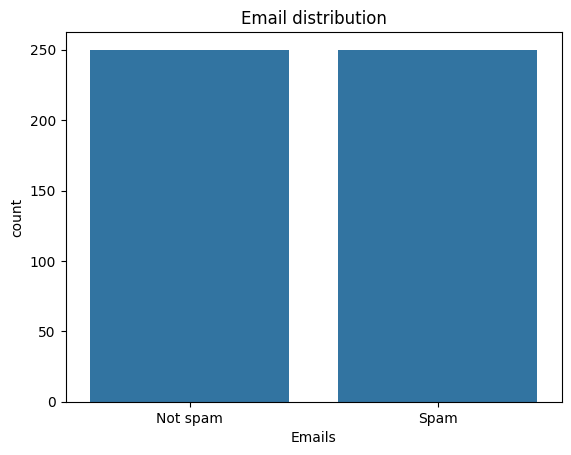

In [8]:
# Rename columns and handle missing values
df = pd.concat([df], ignore_index=True).rename(columns={'Body':'Email','Label':'Spam'})
df.dropna(inplace=True)

# Visualize distribution of spam and non-spam emails
sns.countplot(x='Spam', data=df)
plt.title('Email distribution')
plt.xticks([0,1],['Not spam','Spam'])
plt.xlabel('Emails')
plt.show()

## **3. Data Preprocessing**

In [9]:
import re
import nltk
import pickle
import pandas as pd

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

corpus = []
lemmatizer = WordNetLemmatizer()

for email in df['Email']:
    # Data Cleaning
    removed_tabs_newline = re.sub('[\n|\t]',' ',email)
    removed_subject = re.sub('Subject:',' ',removed_tabs_newline)
    removed_spchar_digits = re.sub('[^a-zA-Z]',' ',removed_subject)
    lower_case_email = removed_spchar_digits.lower()
    tokenized_email = lower_case_email.split()
    filtered_words = [word for word in tokenized_email if word not in stopwords.words('english')]
    lemmetized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    email = ' '.join(lemmetized_words)
    corpus.append(email)

# Creating vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()

# Extracting independent and dependent variables
X = pd.DataFrame(vectors, columns=feature_names)
y = df['Spam']

# Save TF-IDF vectorizer
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **4. Model Building and Training**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Model 1: Multinomial Naive Bayes
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
print('Model score on test data:', classifier.score(X_test, y_test))


Model score on test data: 0.98


## **5. Model Evaluation**

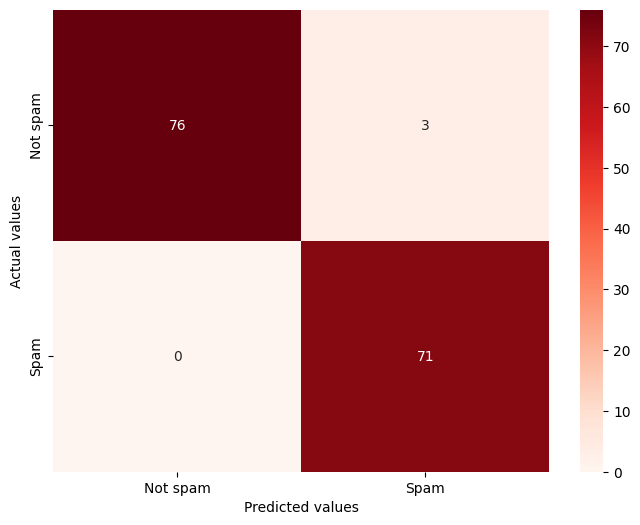

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        79
           1       0.96      1.00      0.98        71

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [11]:
from sklearn.model_selection import cross_val_score

# Cross-validation scores
cross_val_score(classifier, X_test, y_test)

# Predictions and Confusion Matrix
y_predicted = classifier.predict(X_test)
confusion_matrix_result = confusion_matrix(y_test, y_predicted)

# Visualization
labels = ['Not spam','Spam']
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Reds', fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

# Classification Report
classification_report_result = classification_report(y_test, y_predicted)
print(classification_report_result)


## **6. Model Export**


In [12]:
import pickle

# Export the model using pickle
with open('spam_classifier_model.pkl', 'wb') as f:
    pickle.dump(classifier, f)

## **7. Model Import and testing**

In [13]:
# Importing the saved model
with open('spam_classifier_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Testing with an example
example_email = ['Question about the course',]
example_vector = tfidf.transform(example_email).toarray()

# Prediction
prediction = loaded_model.predict(example_vector)
print("Example email is classified as:", "Spam" if prediction[0] == 1 else "Not spam")

Example email is classified as: Not spam


In [21]:
# Testing with an example
# example_email = ['Get 5% off by clicking on this link!!',]
example_email = ['High-severity alert! Please look at your account and update !',]
example_vector = tfidf.transform(example_email).toarray()

# Prediction
prediction = loaded_model.predict(example_vector)
print("Example email is classified as:", "Spam" if prediction[0] == 1 else "Not spam")

Example email is classified as: Spam


# **Part 2: General Information Email**

In [2]:
import email
import os
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

In [3]:
import email
import re
import pickle
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def extract_email_info(eml_file_path, tfidf_vectorizer):
    extracted_info = {}  # Dictionary to store extracted information
    with open(eml_file_path, 'r') as eml_file:
        msg = email.message_from_file(eml_file)

        # Extract message ID, creation date, from, to, number of recipients, subject line
        creation_date = msg.get('Date')
        if creation_date:
            # Parse the creation date to datetime object
            creation_datetime = datetime.strptime(creation_date, "%a, %d %b %Y %H:%M:%S %z")
            # Convert datetime object to day/month/year format
            formatted_creation_date = creation_datetime.strftime("%d/%m/%Y")
            extracted_info['Creation Date'] = formatted_creation_date
        else:
            extracted_info['Creation Date'] = "Unknown"

        extracted_info['From'] = msg.get('From')
        recipients = extract_recipients(msg.get_all('To'))  # Get all recipients
        extracted_info['Recipients'] = recipients
        extracted_info['Number of Recipients'] = len(recipients) if recipients else 1
        extracted_info['Subject'] = msg.get('Subject')

        # Check if there are any attachments and their types
        attachments = []
        for part in msg.walk():
            if part.get_content_maintype() == 'multipart':
                continue
            if part.get_filename():
                attachments.append(part.get_content_type())
        extracted_info['Attachments'] = attachments if attachments else "No attachments detected"

        # Extract and store all links from the email content
        links_info = []
        for part in msg.walk():
            if part.get_content_type().startswith('text/plain') or part.get_content_type().startswith('text/html'):
                email_content = part.get_payload(decode=True).decode(part.get_content_charset())
                links = re.findall(r'<a\s+href="([^"]+?)">([^<]+?)</a>', email_content)  # Extract displayed and actual links
                if links:
                    for actual_link, displayed_link in links:
                        links_info.append({'Displayed Link': displayed_link, 'Actual Link': actual_link})
                        # Compute cosine similarity between the displayed link and the actual link
                        cosine_sim = compute_cosine_similarity(displayed_link, actual_link, tfidf_vectorizer)
                        links_info[-1]['Cosine Similarity'] = cosine_sim
        extracted_info['Links'] = links_info if links_info else "No links detected"

        # Classify the subject
        subject_classification = classify_subject(extracted_info['Subject'], tfidf_vectorizer)
        extracted_info['Classified Subject'] = subject_classification

    return extracted_info

def extract_recipients(recipients):
    extracted_recipients = []
    if recipients:
        for recipient in recipients:
            addresses = re.findall(r'<([\w\.-]+@[\w\.-]+)>', recipient)  # Extract email addresses enclosed in <>
            extracted_recipients.extend(addresses)
    return extracted_recipients

def compute_cosine_similarity(displayed_link, actual_link, tfidf_vectorizer):
    added_link_without_http = re.sub(r'^https?://', '', displayed_link)  # Remove 'http://' from displayed link
    actual_link_without_http = re.sub(r'^https?://', '', actual_link)  # Remove 'http://' from actual link
    vectors = tfidf_vectorizer.transform([added_link_without_http, actual_link_without_http])
    cosine_sim = cosine_similarity(vectors[0:1], vectors[1:]).flatten()[0]
    return cosine_sim

def classify_subject(subject, tfidf_vectorizer):
    # Importing the saved model
    with open('spam_classifier_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)

    # Transform the subject into a vector
    print(subject)
    example_vector = tfidf_vectorizer.transform([subject]).toarray()

    # Prediction
    prediction = loaded_model.predict(example_vector)
    return "Spam" if prediction[0] == 1 else "Not spam"

# Load TF-IDF vectorizer
with open('tfidf.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)


In [4]:
# Usage
eml_file_path = '../Example_emails/email_1.eml'  # Replace with your email file path
email_info = extract_email_info(eml_file_path, tfidf_vectorizer)
print(email_info)

This is a sample mail with a link and attachment !
{'Creation Date': '01/05/2024', 'From': 'Linguo Rank <linguorank@gmail.com>', 'Recipients': [], 'Number of Recipients': 1, 'Subject': 'This is a sample mail with a link and attachment !', 'Attachments': ['image/png', 'text/plain'], 'Links': [{'Displayed Link': 'Displayedlinl.com', 'Actual Link': 'https://www.wikihow.com/Main-Page', 'Cosine Similarity': 0.4281031098342067}], 'Classified Subject': 'Spam'}
